# Class-Project - Media Sentiment and Voting Outcomes

## Topic: Anaylzing Swiss Media Coverage and its Relation to Direct Democratic Decisions

**Description:**  
This project explores how Swiss media coverage—through sentiment and topic analysis—relates to the outcomes of national referenda. Using a dataset of approximately 100–120 newspaper articles covering 20 popular initiatives, we apply Natural Language Processing (NLP) techniques to uncover prevailing themes and emotional tone in the media discourse. The results are then compared to the respective voting outcomes to investigate whether patterns of alignment or divergence emerge between public sentiment and media framing.

*Note: This is an exploratory project and does not aim to establish causal relationships.*

---

## 1. Data Retrieval and Management

Before starting the analysis, we install and import all necessary Python libraries for text preprocessing, sentiment analysis, topic modeling, and visualization.

In [ ]:
# install required packages (pandas, requests, beautifulsoup4, tqdm, wordcloud, spacey, openpyxl, seaborn, nltk) if not already installed
# import
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm


In [11]:
# load data
input_path = "Data_ML.xlsx" 
df = pd.read_excel(input_path)

In [12]:
# inspect data
df.head()

,vote_id,id,voting_date,initiative,yes_share,result,news_article_URL,publication_date,newspaper_name,text
0,1,1,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/tell-srebrenica-und...,2011-01-09,20min,NaN
1,1,2,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/abstimmung-mit-prom...,2011-02-08,20min,NaN
2,1,3,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/daempfer-fuer-schut...,2011-01-04,20min,NaN
3,1,4,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/kommission-lehnt-wa...,2011-01-04,20min,NaN
4,1,5,2011-02-13,Für den Schutz vor Waffengewalt,0.437,Abgelehnt,https://www.20min.ch/story/waffenlobby-wittert...,2011-01-13,20min,NaN


Based on a comprehensive list of Swiss national initiatives, we randomly selected 20 initiatives from the past 20 years, covering nearly 80% of total initiatives in this time span. Using AI-assisted search, we identified relevant news articles from three major Swiss news outlets: SRF, NZZ, and 20 Minuten, all published **prior to the respective votes**. Since NZZ requires a login to access full articles, automated scraping was not feasible in that case, and those texts were therefore added manually.

In the following section, we define a function to automatically scrape the article texts from the remaining two outlets – SRF and 20 Minuten – using their publicly available URLs.


In [13]:
# Function to scrape URL and extract text
def extract_text_from_url(url):
    try:
        headers = {
            "User-Agent": "Mozilla/5.0"
        }
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code != 200:
            return None
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        text = " ".join(p.get_text().strip() for p in paragraphs)
        return text if text else None
    except Exception as e:
        print(f"Fehler bei URL: {url} → {e}")
        return None

# === 3. Filter: Nur Artikel ohne NZZ, mit gültiger URL, und leerem Text ===
df_scrape = df[
    (~df["newspaper_name"].str.lower().str.contains("nzz", na=False)) &
    (~df["news_article_URL"].isnull()) &
    (df["text"].isnull() | (df["text"].str.strip() == ""))
]

# === 4. Scraping starten und in bestehende 'text'-Spalte einfügen ===
for idx in tqdm(df_scrape.index):
    url = df.at[idx, "news_article_URL"]
    text = extract_text_from_url(url)
    df.at[idx, "text"] = text

# === 5. Neue Excel-Datei speichern (im gleichen Ordner) ===
output_path = "Data_ML_filled.xlsx"
df.to_excel(output_path, index=False)
print(f"✅ Fertig! Gespeichert als: {output_path}")





100%|██████████| 76/76 [00:41<00:00,  1.85it/s]

✅ Fertig! Gespeichert als: Data_ML_filled.xlsx


Load the new dataset for following analysis and inspect the texts to find re-occuring wording and phrases not related to the article

In [14]:
# load new data
input_path = "Data_ML_filled.xlsx" 
df_new = pd.read_excel(input_path)


In [15]:
# show 5 random articles with text longer than 50 characters
df_sample = df[df["text"].notnull() & (df["text"].str.len() > 50)].sample(5, random_state=1)

# print the sample articles
pd.set_option('display.max_colwidth', None)
df_sample[["newspaper_name", "news_article_URL", "text"]]

newspaper_name  \
104          20min   
94           20min   
96             srf   
93             nzz   
105          20min   

                                                                                                                              news_article_URL  \
104                                https://www.20min.ch/story/abstimmung-darum-warnt-der-bundesrat-vor-der-biodiversitaetsinitiative-103171217   
94                                                   https://www.20min.ch/story/13-ahv-rente-linke-eroeffnen-den-abstimmungskampf-557637387047   
96   https://www.srf.ch/sendungen/kassensturz-espresso/kassensturz/abstimmung-am-3-maerz-2024-die-13-ahv-rente-sorgt-fuer-hitzige-diskussionen   
93                                         https://www.nzz.ch/schweiz/13-ahv-rente-die-linke-mobilisiert-gezielt-frauen-fuer-ein-ja-ld.1814584   
105                    https://www.20min.ch/story/chunsch-drus-darum-gehts-deshalb-spaltet-die-biodiversitaets-abstimmung-die-bauern-103167786   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Upon closer inspection of the raw article texts, we identified systematic non-content elements in both SRF and 20 Minuten articles. These include login instructions, app banners, author lines, and embedded lists of unrelated games or features that frequently appear at the beginning or end of the articles. As these components are not part of the actual journalistic content, we exclude them from the dataset in the following step using tailored cleaning functions for each news outlet.


In [16]:
# Clean SRF articles by removing known junk phrases and footer blocks
def clean_srf_text(text):
    if not isinstance(text, str):
        return text

    # 1. Remove known static junk phrases
    garbage_phrases = [
        "Einige Elemente auf SRF.ch funktionieren nur mit aktiviertem JavaScript",
        "SRF News App Bei Google Play",
        "In der App öffnen"
    ]
    for phrase in garbage_phrases:
        if phrase in text:
            text = text.replace(phrase, "")

    # 2. Remove dynamic noisy patterns (author info, footer, etc.)
    text = re.sub(r"Autor:\s*\n?.*?\d{2}\.\d{2}\.\d{4}, \d{2}:\d{2}", "", text)
    text = re.sub(r"Für die Registrierung benötigen wir.*", "", text)
    text = re.sub(r"Bitte melden Sie sich an, um einen Kommentar zu erfassen.*", "", text)

    return text.strip()


# Apply SRF cleaning to all SRF articles
mask_srf = df_new["newspaper_name"].str.lower().str.contains("srf", na=False)
df_new.loc[mask_srf, "text"] = df_new.loc[mask_srf, "text"].apply(clean_srf_text)


# Clean 20min articles by removing game lists and footer elements
def clean_20min_text(text):
    if not isinstance(text, str):
        return text
    
    garbage_words_20min = [
    "Deine Meinung zählt", "Solitaire", "Kreuzworträtsel", "Sudoku", "Mahjong", "Bubbles",
    "Snake", "Schach", "eXchange", "Power of 2", "Doppel", "Cuboro", "Riddles", "Wortblitz",
    "SudoKen", "Street", "Fibonacci", "Gumblast", "Rushtower", "Skiracer", "Wimmlbid", "(sda)"
]
    
    for phrase in garbage_words_20min:
        text = text.replace(phrase, "")

    return text.strip()

# Apply 20min cleaning to all 20 Minuten articles
mask_20min = df_new["newspaper_name"].str.lower().str.contains("20", na=False)
df_new.loc[mask_20min, "text"] = df_new.loc[mask_20min, "text"].apply(clean_20min_text)





Print random articles form 20min and SRF to insepct if there are still some remaining non-content elements.

In [18]:
pd.set_option('display.max_colwidth', None)  # show full text content

# Show 5 random cleaned SRF and 5 random 20min articles
sample_srf = df_new[mask_srf & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=1)
sample_20min = df_new[mask_20min & df_new["text"].notnull() & (df_new["text"].str.len() > 100)].sample(5, random_state=2)

display(sample_srf[["newspaper_name", "news_article_URL", "text"]])
display(sample_20min[["newspaper_name", "news_article_URL", "text"]])

newspaper_name  \
14            srf   
83            srf   
15            srf   
66            srf   
79            srf   

                                                                                                   news_article_URL  \
14  https://www.srf.ch/news/schweiz/masseneinwanderungs-initiative-die-auslaender-kommen-die-schweiz-unter-zugzwang   
83               https://www.srf.ch/radio-srf-1/abstimmung-am-13-februar-tierversuchsverbotsinitiative-ja-oder-nein   
15   https://www.srf.ch/news/schweiz/paedophilen-initiative-paedophile-sollen-nie-mehr-mit-kindern-arbeiten-duerfen   
66                  https://www.srf.ch/news/abstimmung-von-26-september-99-prozent-initiative-spaltet-die-meinungen   
79                  https://www.srf.ch/radio-srf-1/justizinitiative-richterwahl-im-losverfahren-die-bessere-loesung   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

newspaper_name  \
42          20min   
43          20min   
88          20min   
30          20min   
94          20min   

                                                                                                    news_article_URL  \
42                              https://www.20min.ch/story/bundesrat-lehnt-die-begrenzungsinitiative-ab-983134565504   
43                     https://www.20min.ch/story/was-geschieht-wenn-die-svp-initiative-angenommen-wird-433791918637   
88  https://www.20min.ch/story/das-musst-du-zur-initiative-fuer-ein-verbot-der-massentierhaltung-wissen-177410670324   
30                           https://www.20min.ch/story/der-bestatter-greift-in-die-billag-schlacht-ein-191657448417   
94                         https://www.20min.ch/story/13-ahv-rente-linke-eroeffnen-den-abstimmungskampf-557637387047   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [19]:
## download the file to manually inspect:
df_new.to_excel("Data_ML_bereinigt.xlsx", index=False)

## 2. Descriptive Analysis and Visualizations

This section provides an overview of the cleaned dataset and explores basic structural properties of the collected newspaper articles. While descriptive statistics are often used to identify first empirical patterns or directional effects, this task is less straightforward in natural language data. In textual analysis, descriptive steps typically serve to better understand the composition and structure of the data — for example, article distribution across sources and topics, variation in text length, or the frequency of certain keywords.

In the context of our project, we investigate whether newspaper coverage reflects political sentiment or voter preferences in the run-up to Swiss national votes. The dataset consists of approximately 120 articles related to 20 federal initiatives, making it relatively small and unevenly distributed across media outlets. These limitations must be kept in mind when interpreting patterns.

Nonetheless, this section aims to characterize the dataset in a meaningful way. We visualize article distributions, compare structural features (e.g., text length), and explore word frequencies to uncover initial content-related differences between media sources or accepted vs. rejected initiatives.

### 2.1 Distribution of Articles by News Outlet

The following bar chart shows how many articles in the dataset originate from each news outlet. This helps assess the balance of sources and identify any potential dominance by a single media platform.

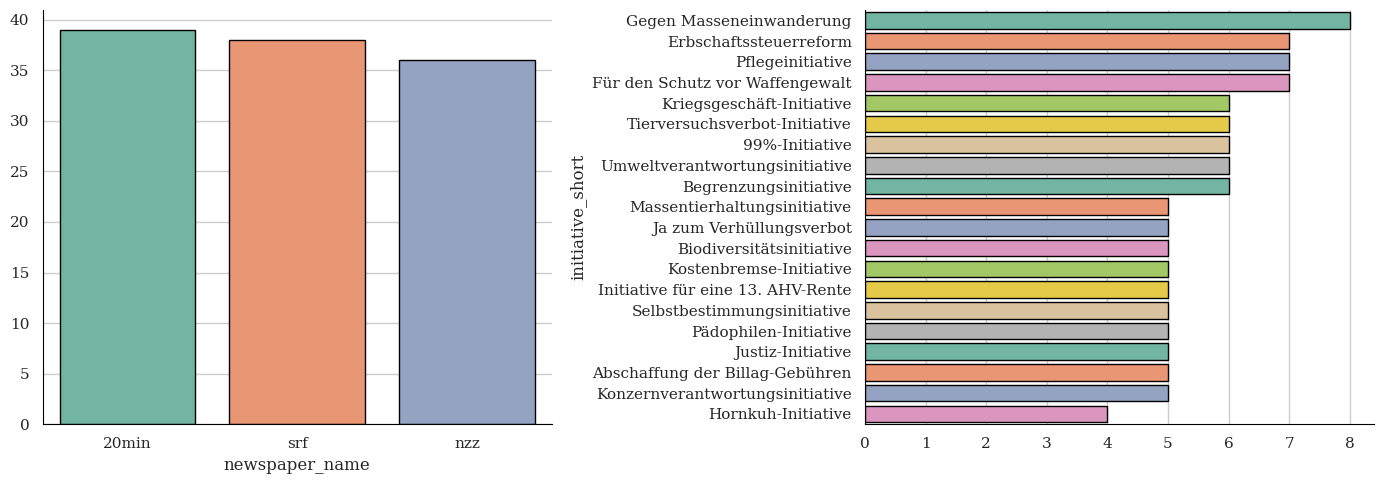

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

# === 1. Manuelle Zuordnung für spezifische Initiativen ohne Klammer ===
manual_shortnames = {
    "Für verantwortungsvolle Unternehmen – zum Schutz von Mensch und Umwelt": "Konzernverantwortungsinitiative",
    "Ja zum Tier- und Menschenversuchsverbot – Ja zu Forschungswegen mit Impulsen für Sicherheit und Fortschritt": "Tierversuchsverbot-Initiative",
    "Pädophile sollen nicht mehr mit Kindern arbeiten dürfen": "Pädophilen-Initiative"
}

# === 2. Funktion zur Extraktion bzw. Zuweisung eines Kurztitels ===
def get_short_title(title):
    if not isinstance(title, str):
        return title
    # Falls in Mapping manuell definiert
    if title in manual_shortnames:
        return manual_shortnames[title]
    # Falls etwas in Klammern steht, das extrahieren
    match = re.search(r"\((.*?)\)", title)
    if match:
        return match.group(1)
    # Fallback: Originaltitel
    return title

# Neue Spalte mit Kurzbezeichnung
df_new["initiative_short"] = df_new["initiative"].apply(get_short_title)

# === 3. Visual Style ===
sns.set_theme(style="whitegrid", context="notebook", font="serif")
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "font.family": "serif",
})

# === 4. Daten für die Plots ===
article_counts = df_new["newspaper_name"].value_counts()
initiative_counts = df_new["initiative_short"].value_counts().sort_values(ascending=False)

# === 5. Zwei Plots nebeneinander ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Articles per News Outlet
sns.barplot(
    x=article_counts.index,
    y=article_counts.values,
    hue=article_counts.index,      
    legend=False,                  
    palette="Set2",
    edgecolor="black",
    ax=axes[0]
)

# Plot 2: Articles per Initiative
sns.barplot(
    y=initiative_counts.index,
    x=initiative_counts.values,
    hue=initiative_counts.index,    
    legend=False,
    palette="Set2",
    edgecolor="black",
    ax=axes[1]
)


sns.despine()
plt.tight_layout()
plt.show()



**Interpretation**

The dataset includes a relatively balanced number of articles from all three major Swiss news outlets under consideration. 20 Minuten and SRF each contribute close to 40 articles, while NZZ is slightly less represented with around 36 articles. This distribution suggests that no single outlet dominates the dataset, which is beneficial for a more unbiased analysis of media content.


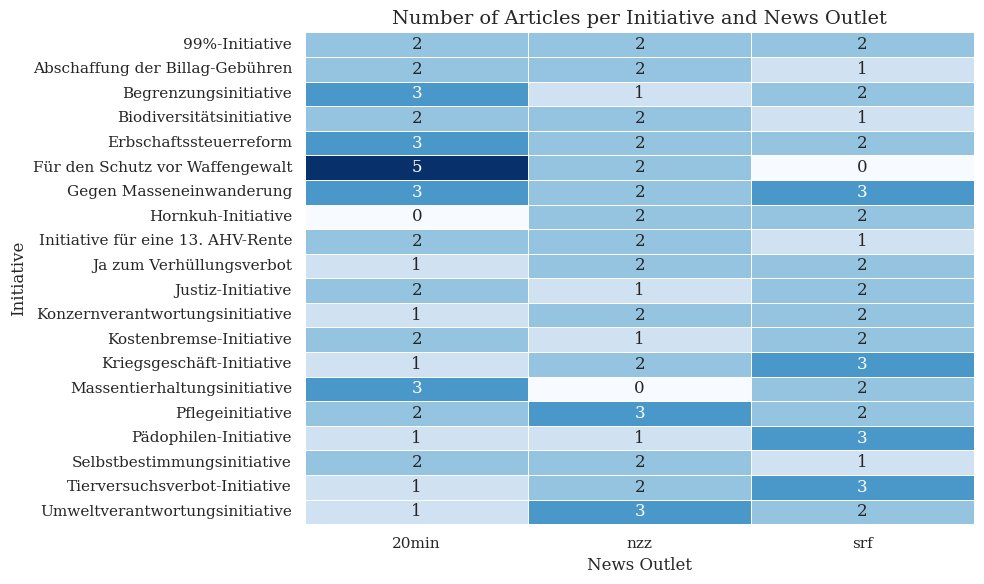

In [23]:
# Pivot-Tabelle: Anzahl Artikel pro Medium und Initiative
pivot = df_new.pivot_table(index="initiative_short", columns="newspaper_name", aggfunc="size", fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues", cbar=False, linewidths=0.5)
plt.title("Number of Articles per Initiative and News Outlet")
plt.xlabel("News Outlet")
plt.ylabel("Initiative")
plt.tight_layout()
plt.show()

### 2.2 Distribution of Article Lengths

To better understand the informational content of the articles, we examine their length as measured by the number of characters. This helps assess whether certain media outlets tend to publish longer or more concise texts. While article length alone does not imply depth or quality, it can be a useful proxy for content richness.

The following histogram shows the distribution of article lengths across all sources.


C:\Users\valen\AppData\Local\Temp\ipykernel_15528\649895327.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_new, x="newspaper_name", y="text_length", palette="Set2", ax=axes[1])


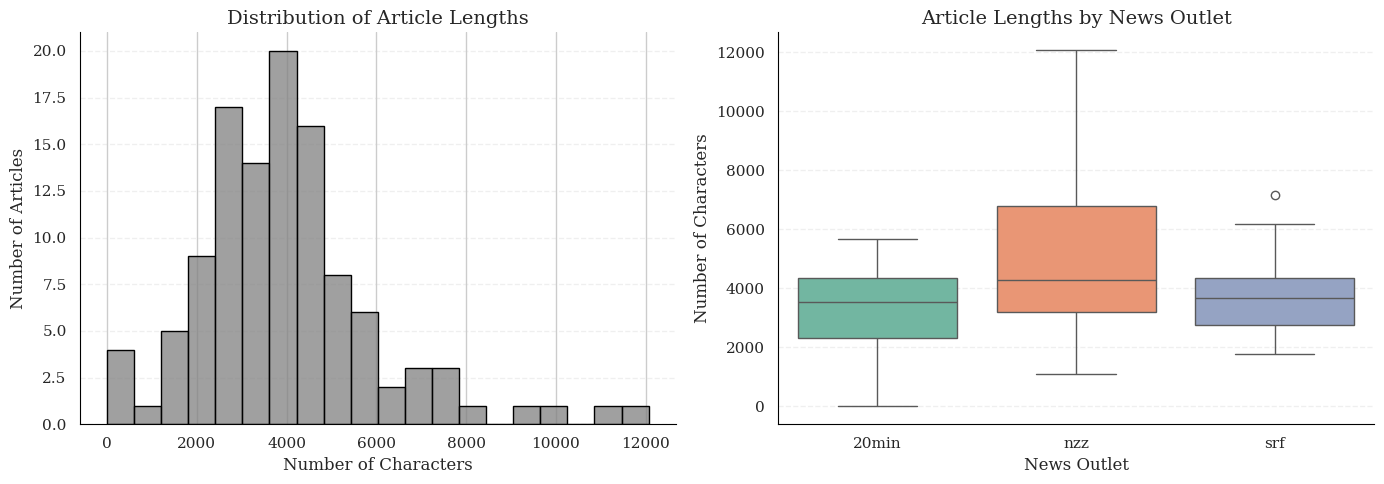

In [24]:
# Textlänge berechnen (falls noch nicht gemacht)
df_new["text_length"] = df_new["text"].apply(lambda x: len(x) if isinstance(x, str) else 0)

# Set up subplot layout
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Histogram
sns.histplot(data=df_new, x="text_length", bins=20, kde=False, color="gray", edgecolor="black", ax=axes[0])
axes[0].set_title("Distribution of Article Lengths")
axes[0].set_xlabel("Number of Characters")
axes[0].set_ylabel("Number of Articles")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)

# Plot 2: Boxplot by Outlet
sns.boxplot(data=df_new, x="newspaper_name", y="text_length", palette="Set2", ax=axes[1])
axes[1].set_title("Article Lengths by News Outlet")
axes[1].set_xlabel("News Outlet")
axes[1].set_ylabel("Number of Characters")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)

# Clean up
sns.despine()
plt.tight_layout()
plt.show()



**Interpretation**

The histogram on the left shows the overall distribution of article lengths in the dataset. Most articles range between 2,000 and 5,000 characters, with a few longer texts exceeding 10,000 characters. This right-skewed distribution suggests that while most coverage remains relatively concise, some articles offer more detailed reporting.

The boxplot on the right breaks down article lengths by media outlet. It shows that *NZZ* tends to publish longer articles compared to *20 Minuten* and *SRF*. This is consistent with NZZ’s reputation as a more in-depth and analysis-oriented outlet. The other two sources, especially 20 Minuten, produce more compact texts on average.


### 2.3 Wordclouds by Voting Outcome

To explore whether articles differ in their language depending on the outcome of a vote, we generate two wordclouds: one for initiatives that were accepted and one for those that were rejected. This allows for a visual comparison of the most frequent terms in media coverage, highlighting differences in topic emphasis, tone, or framing across accepted and rejected proposals.

While not a precise analytical tool, wordclouds help uncover general patterns and are a useful exploratory step before more formal NLP methods.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


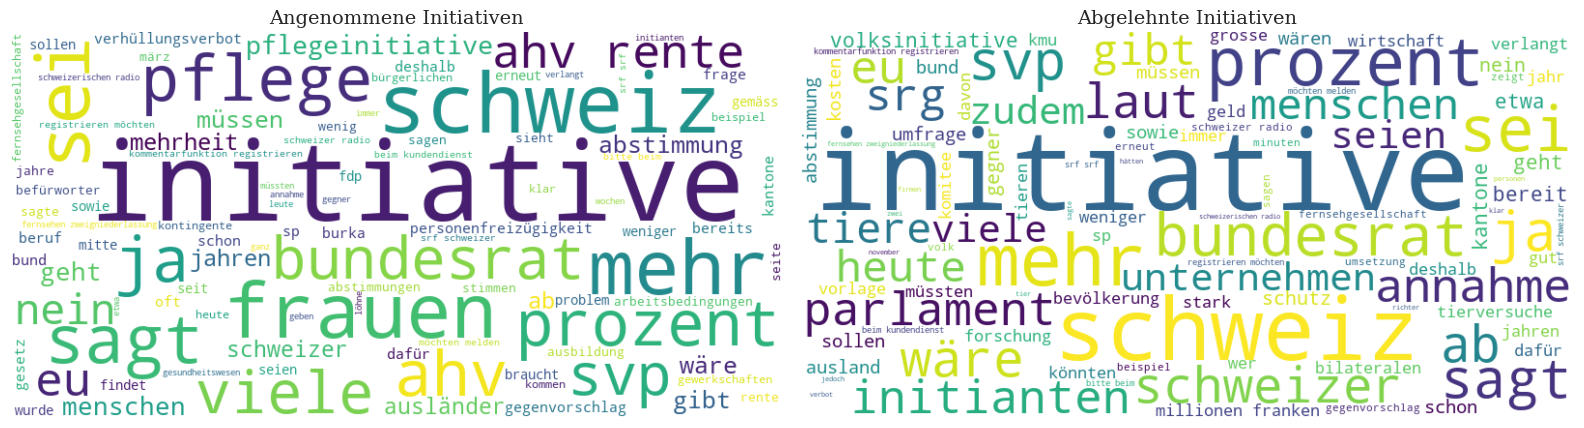

In [27]:
import nltk
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download("stopwords")

# Kombinierte Stopwords (Deutsch + Standard)
combined_stopwords = set(STOPWORDS)
combined_stopwords.update(stopwords.words("german"))

# Ergebnisspalte säubern
df_new["result_clean"] = df_new["result"].str.strip().str.lower()

# Texte extrahieren
text_yes = " ".join(df_new[df_new["result_clean"] == "angenommen"]["text"].dropna()).lower()
text_no = " ".join(df_new[df_new["result_clean"] == "abgelehnt"]["text"].dropna()).lower()

# Wordclouds
wc_yes = WordCloud(width=800, height=400, background_color="white",
                   max_words=100, stopwords=combined_stopwords).generate(text_yes)

wc_no = WordCloud(width=800, height=400, background_color="white",
                  max_words=100, stopwords=combined_stopwords).generate(text_no)

# Anzeigen
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(wc_yes, interpolation="bilinear")
axes[0].axis("off")
axes[0].set_title("Angenommene Initiativen", fontsize=14)

axes[1].imshow(wc_no, interpolation="bilinear")
axes[1].axis("off")
axes[1].set_title("Abgelehnte Initiativen", fontsize=14)

plt.tight_layout()
plt.show()



**Interpretation**

The word clouds above provide an overview of the most frequently occurring **words** in news articles related to accepted (*Angenommene*) and rejected (*Abgelehnte*) Swiss initiatives. While some overlap is visible—such as the prominence of general terms like *Initiative*, *Schweiz* (Switzerland), *Bundesrat* (Federal Council), and *Prozent* (percent)—clear thematic differences also emerge.

In articles covering **accepted initiatives**, socially and welfare-oriented terms appear more frequently. Notable examples include:
- *Pflegeinitiative* (nursing initiative),
- *AHV* (state pension insurance),
- *Rente* (pension),
- *Frauen* (women),
- *Arbeitsbedingungen* (working conditions).

These terms suggest a focus on social protection, care-related reforms, and gender equality.

In contrast, **rejected initiatives** are more associated with political and economic vocabulary:
- *Unternehmen* (companies),
- *Tierversuche* (animal testing),
- *EU*, *Wirtschaft* (economy),
- *Parlament* (parliament),
- *Initianten* (initiators).

This pattern may imply that proposals involving controversial topics, regulatory shifts, or international relations face more public resistance.

Additionally, articles related to rejected initiatives often contain more speculative or indirect language—e.g., *wäre* (would be), *bereit* (ready), or *laut* (according to)—indicating a more uncertain or tentative tone.

Overall, the word clouds visually hint at a potential trend: initiatives with concrete social benefits are more likely to be accepted, while those concerning broader systemic changes or contested domains tend to be rejected.


### 2.4 Topic Modeling with BERTopic

To explore the thematic structure of media coverage, we apply topic modeling using BERTopic. Unlike word clouds, which highlight the frequency of individual words, topic modeling groups semantically related terms into interpretable topics. This allows us to uncover dominant themes that span across articles.

We use BERTopic, a modern topic modeling approach based on transformer embeddings and clustering, to identify recurring topics within our dataset. This helps assess whether certain topics dominate the media discourse surrounding accepted versus rejected initiatives.

Due to our limited dataset size, results are interpreted qualitatively, focusing on thematic differences rather than statistical inference.

In [33]:
%pip install protobuf tiktoken


   ---------------------------------------- 0.0/894.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/894.0 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/894.0 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 894.0/894.0 kB 1.6 MB/s eta 0:00:00

   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 0/2 [protobuf]
   ---------------------------------------- 2/2 [tiktoken]

Note: you may need to restart the kernel to use updated packages.


In [34]:
#%pip install transformers
#%pip install torch

from transformers import pipeline

# Zero-Shot Klassifikator (multilingual tauglich)
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

# Beispiel-Labels
candidate_labels = ["Wirtschaft", "Umwelt", "Migration", "Gesundheit", "Sicherheit", "Soziales", "Bildung", "Steuern"]

# Beispieltext (du kannst hier deine df_new Texte iterieren lassen)
example_text = df_new["text"].dropna().iloc[0]

# Klassifizieren
result = classifier(example_text, candidate_labels, multi_label=True)
print(result)



Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ValueError: Converting from SentencePiece and Tiktoken failed, if a converter for SentencePiece is available, provide a model path with a SentencePiece tokenizer.model file.Currently available slow->fast converters: ['AlbertTokenizer', 'BartTokenizer', 'BarthezTokenizer', 'BertTokenizer', 'BigBirdTokenizer', 'BlenderbotTokenizer', 'CamembertTokenizer', 'CLIPTokenizer', 'CodeGenTokenizer', 'ConvBertTokenizer', 'DebertaTokenizer', 'DebertaV2Tokenizer', 'DistilBertTokenizer', 'DPRReaderTokenizer', 'DPRQuestionEncoderTokenizer', 'DPRContextEncoderTokenizer', 'ElectraTokenizer', 'FNetTokenizer', 'FunnelTokenizer', 'GPT2Tokenizer', 'HerbertTokenizer', 'LayoutLMTokenizer', 'LayoutLMv2Tokenizer', 'LayoutLMv3Tokenizer', 'LayoutXLMTokenizer', 'LongformerTokenizer', 'LEDTokenizer', 'LxmertTokenizer', 'MarkupLMTokenizer', 'MBartTokenizer', 'MBart50Tokenizer', 'MPNetTokenizer', 'MobileBertTokenizer', 'MvpTokenizer', 'NllbTokenizer', 'OpenAIGPTTokenizer', 'PegasusTokenizer', 'Qwen2Tokenizer', 'RealmTokenizer', 'ReformerTokenizer', 'RemBertTokenizer', 'RetriBertTokenizer', 'RobertaTokenizer', 'RoFormerTokenizer', 'SeamlessM4TTokenizer', 'SqueezeBertTokenizer', 'T5Tokenizer', 'UdopTokenizer', 'WhisperTokenizer', 'XLMRobertaTokenizer', 'XLNetTokenizer', 'SplinterTokenizer', 'XGLMTokenizer', 'LlamaTokenizer', 'CodeLlamaTokenizer', 'GemmaTokenizer', 'Phi3Tokenizer']